# Introduction to JUDI

[JUDI.jl](https://github.com/slimgroup/JUDI.jl) is a framework for large-scale seismic modeling and inversion and designed to enable rapid translations of algorithms to fast and efficient code that scales to industry-size 3D problems. The focus of the package lies on seismic modeling as well as PDE-constrained optimization such as full-waveform inversion (FWI) and imaging (LS-RTM). Wave equations in JUDI are solved with [Devito](https://www.devitoproject.org), a Python domain-specific language for automated finite-difference (FD) computations. JUDI's modeling operators can also be used as layers in (convolutional) neural networks to implement physics-augmented deep learning algorithms. For this, check out JUDI's deep learning extension [JUDI4Flux](https://github.com/slimgroup/JUDI4Flux.jl).

The JUDI software is published in [Witte, Philipp A., et al. "A large-scale framework for symbolic implementations of seismic inversion algorithms in Julia." Geophysics 84.3 (2019): F57-F71.](https://library.seg.org/doi/10.1190/geo2018-0174.1).

This tutorial covers the following topics:

1. How to set up the geometry/acquisition in a seismic experiment
2. How software abstraction in Julia plays in role in the modeling via the abstracted linear operators
3. How to set up a mini-cluster to run seismic experiments parallel over shots

In [1]:
using JUDI, PyPlot, LinearAlgebra, Test

`DEVITO_OPENMP` is deprecated. DEVITO_LANGUAGE=openmp should be used instead
Both `DEVITO_OPENMP` and `DEVITO_LANGUAGE` set. Ignoring `DEVITO_OPENMP`


# Physical problem setup
## Grid
JUDI relies on a cartesian grid for modeling and inversion. We start by defining the parameters needed for a cartesian grid:
 - A shape
 - A grid spacing in each direction
 - An origin

In [2]:
shape = (201, 201) # Number of gridpoints nx, nz
spacing = (10.0, 10.0) # in meters here
origin = (0.0, 0.0) # in meters as well

(0.0, 0.0)

## Physical object

JUDI defines a few basic types to handle physical object such as the velocity model. The type `PhyisicalParameter` is an [AbstractVector](https://docs.julialang.org/en/v1/manual/interfaces/#man-interface-array) and behaves as a standard vector.
A `PhysicalParameter` can be constructed in various ways but always require the origin `o` and grid spacing `d` that
cannot be infered from the array.

    PhysicalParameter(v::Array{vDT}, d, o) where `v` is an n-dimensional array and n=size(v)

    PhysicalParameter(n, d, o; vDT=Float32) Creates a zero PhysicalParameter

    PhysicalParameter(v::Array{vDT}, A::PhysicalParameter) Creates a PhysicalParameter from the Array `v` with n, d, o from `A`

    PhysicalParameter(v::Array{vDT, N}, n::Tuple, d::Tuple, o::Tuple) where `v` is a vector or nd-array that is reshaped into shape `n`

    PhysicalParameter(v::vDT, n::Tuple, d::Tuple, o::Tuple) Creates a constant (single number) PhyicalParameter


Let's make a simple three layer velocity model

In [3]:
# Define the velocity (in km/sec=m/ms)
vp = 1.5f0 * ones(Float32, shape)
vp[:, 66:end] .= 2.0f0
vp[:, 134:end] .= 2.5f0
# Create a physical parameter
VP = PhysicalParameter(vp, spacing, origin);

Let's plot the velocities. Because we adopt a standard cartesian dimension ordering for generality (X, Z) in 2D and (X, Y, Z) in 3D, we plot the transpose of the velocity for proper visualization.

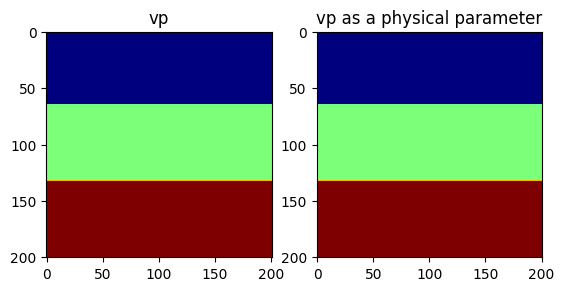

PyObject Text(0.5, 1.0, 'vp as a physical parameter')

In [4]:
figure()
subplot(121)
imshow(vp', cmap="jet")
title("vp")
subplot(122)
imshow(VP', cmap="jet")
title("vp as a physical parameter")

Because the physical parameter behaves as vector, we can easily perform standard operations on it.

In [5]:
norm(VP), extrema(VP), 2f0 .* VP, VP .^ 2

(411.6956f0, (1.5f0, 2.5f0), PhysicalParameter{Float32} of size (201, 201) with origin (0.0, 0.0) and spacing (10.0, 10.0), PhysicalParameter{Float32} of size (201, 201) with origin (0.0, 0.0) and spacing (10.0, 10.0))

## Model

JUDI then provide a `Model` structure that wraps multiple physical parameters together.

In [6]:
model = Model(shape, spacing, origin, 1f0./vp.^2f0)

Model (n=(201, 201), d=(10.0, 10.0), o=(0.0, 0.0)) with parameters [:m]

# Modeling 
Now that we have a seismic model, we will generate a few shot records.

## Acquisition Geometry
The first thing we need is an acquisiton geometry. In JUDI there is two ways to create a Geometry.
- By hand, as we will show here
- From a SEGY file, as we will show in a follow-up tutorial

We create a split-spread geomtry with sources at the top and receivers at the ocean bottom (top of second layer).

**Note**:
- For 2D simulation (i.e. wave propagation in a 2D plane), JUDI still takes y-coordinate of source/receiver locations but we can just put them to 0 anyway.

In [7]:
# Sources position
nsrc = 11
xsrc = range(0f0, (shape[1] -1)*spacing[1], length=nsrc)
ysrc = 0f0 .* xsrc # this a 2D case so we set y to zero
zsrc = 12.5f0*ones(Float32, nsrc);

Now this definition creates a single Array of position, which would correspond to a single Simultenous source. Since we are interested in single source experiments here, we convert these position into an Array of Array
of size `nsrc` where each sub-array is a single source position

In [8]:
xsrc, ysrc, zsrc = convertToCell.([xsrc, ysrc, zsrc]);

In [9]:
# OBN position
nrec = 101
xrec = range(0f0, (shape[1] -1)*spacing[1], length=nrec)
yrec = 0f0 # this a 2D case so we set y to zero. This can be a single number for receivers
zrec = (66*spacing[1])*ones(Float32, nrec);

The last step to be able to create and acquisiton geometry is to define a recording time and sampling rate

In [10]:
record_time = 2000f0 # Recording time in ms (since we have m/ms for the velocity)
sampling_rate = 4f0; # Let's use a standard 4ms sampling rate

Now we can create the source and receivers geometry

In [11]:
src_geom = Geometry(xsrc, ysrc, zsrc; dt=sampling_rate, t=record_time)
# For the receiver geometry, we specify the number of source to tell JUDI to use the same receiver position for all sources
rec_geom = Geometry(xrec, yrec, zrec, dt=sampling_rate, t=record_time, nsrc=nsrc);

Let's visualize the geometry onto the model

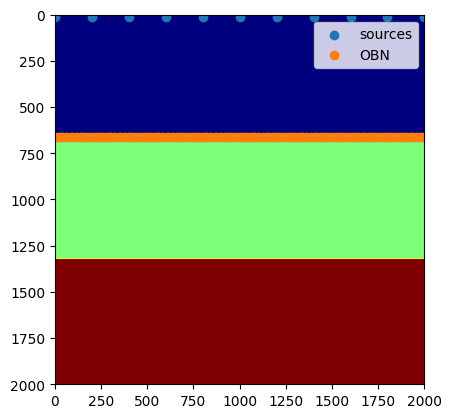

PyObject <matplotlib.legend.Legend object at 0x7f9c72ab9b90>

In [12]:
figure();
imshow(vp', cmap="jet", extent=[0, (shape[1]-1)*spacing[1], (shape[2]-1)*spacing[2], 0])
scatter(xsrc, zsrc, label=:sources)
scatter(xrec, zrec, label="OBN")
legend()

### Source wavelet
For the source wavelet, we will use a standard Ricker wavelet at 10Hz for this tutorial.In practice this wavelet would be read from a file or estimated during inversion. 

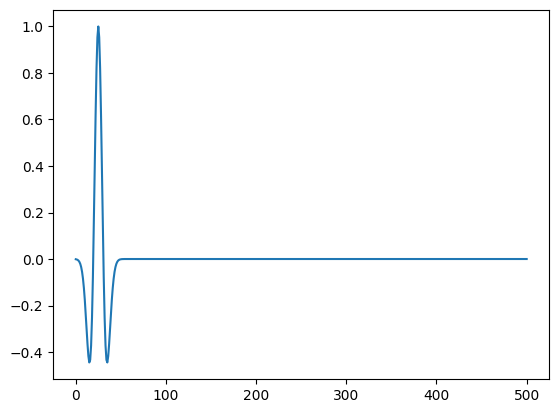

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9c74f19290>

In [13]:
f0 = 0.010 # Since we use ms, the frequency is in KHz
wavelet = ricker_wavelet(record_time, sampling_rate, f0);
plot(wavelet)

## judiVector

In order to represent seismic data, JUDI provide the `judiVector` type. This type wraps a geometry with the seismic data corresponding to it. Let's cretae one for the source

In [14]:
q = judiVector(src_geom, wavelet)

judiVector{Float32, Matrix{Float32}} with 11 sources


# Linear operator
The last step to model our seismic data os to create the linear operator representing the discretized wave equation on the Model we defined. We also need to define the linear operator corresponding to the source injection and the receiver interpolation.
These operators need a few more information in order to define their own size since they behave as "matrices".

In [15]:
Pr = judiProjection(rec_geom) # receiver interpolation
Ps = judiProjection(src_geom) # Source interpolation
Ainv = judiModeling(model) # Inverse of the disrete ewave equation.

JUDI forward{Float32} propagator (x * z * time) -> (x * z * time)

**WARNING**
While these three operator are well defined in JUDI, `judiProjection` is a no-op operator and cannot be used by itself but only in combination with a `judiModeling` operator

# Seismic data generation

Following the math, the seismic data recorded at the receiver locations can be calculated by

$$\mathbf{d}_{obs} = \mathbf{P}_r  \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^{\top}\mathbf{q},$$

Here, $\mathbf{q}$ is the source wavelet set up at the firing locations (defined above). $\mathbf{P}_s^{\top}$ injects $\mathbf{q}$ to the entire space. $\mathbf{A}(\mathbf{m})$ is the discretized wave equation parameterized by squared slowness $\mathbf{m}$. By applying the inverse of $\mathbf{A}(\mathbf{m})$ on source $\mathbf{q}$, we acquire the entire wavefield in the space. Finally, $\mathbf{P}_r$ restricts the wavefield at the receiver locations at the recording time.

Now that we have all our operators setup we can finally generate synthetic data with simple mat-vec product thanks to the abstraction

In [16]:
d_obs = Pr * Ainv * Ps' * q

Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.18 s


judiVector{Float32, Matrix{Float32}} with 11 sources


Similarly, we can define a modeling operator ``F`` that combines the modeling operator with source/receiver restriction operators, as

In [17]:
F = Pr * Ainv * Ps'

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)

We can run the same code to generate the data

In [18]:
d_obs = F * q

Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.19 s
Operator `forward` ran in 0.20 s
Operator `forward` ran in 0.18 s
Operator `forward` ran in 0.18 s


judiVector{Float32, Matrix{Float32}} with 11 sources


There are 11 sources in this experiment, and the data is generated for each shot independently. If we only want to acquire the data for the 6th source for example, then we can run

In [19]:
d_obs6 = F[6] * q[6]

Operator `forward` ran in 0.18 s


judiVector{Float32, Matrix{Float32}} with 1 sources


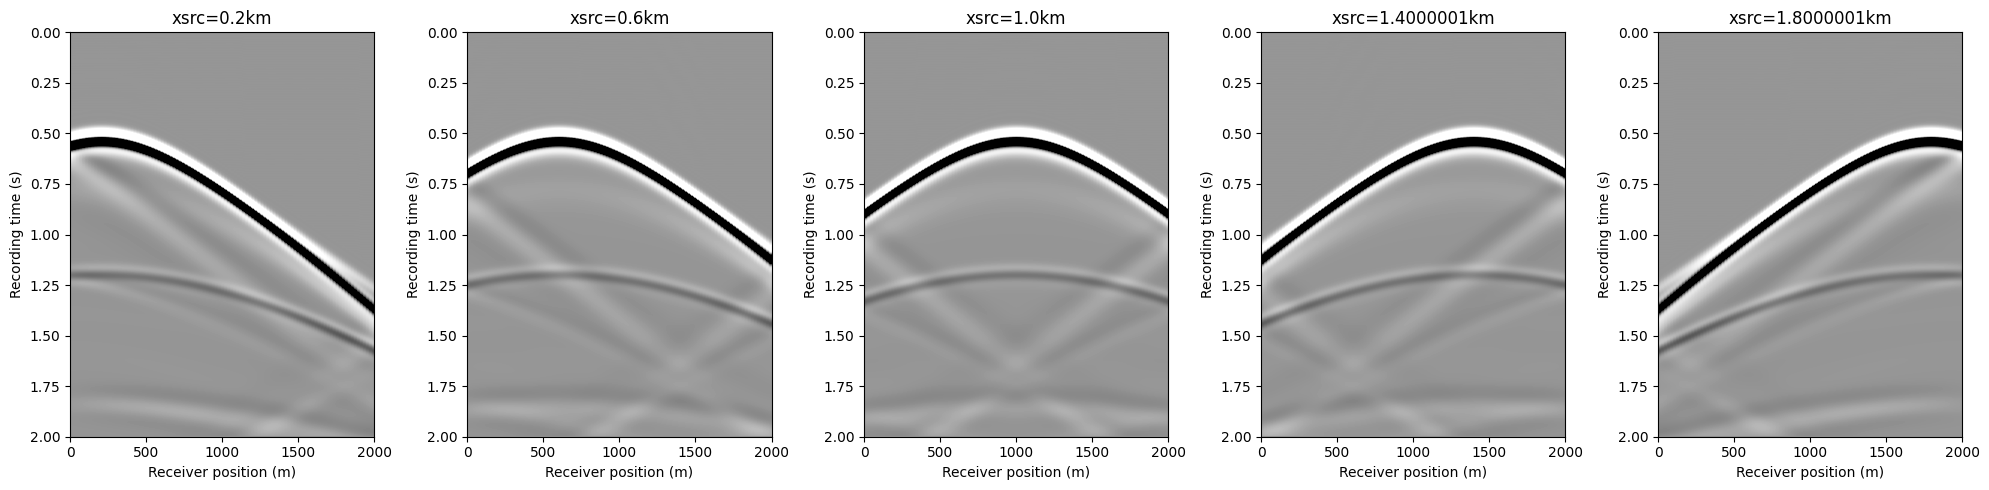

In [20]:
data_extent = [xrec[1], xrec[end], 1f-3*record_time, 0]
figure(figsize=(20, 5))
for i=1:5
    subplot(1, 5, i)
    imshow(d_obs.data[2*i], vmin=-1, vmax=1, cmap="Greys", extent=data_extent, aspect="auto")
    xlabel("Receiver position (m)")
    ylabel("Recording time (s)")
    title("xsrc=$(1f-3xsrc[2*i][1])km")
end
tight_layout()

## Parallelization -- workers and threads

JUDI (based on Devito) uses shared memory OpenMP parallelism for solving PDEs. Here, we show how to build up a small 2-worker cluster by calling `addprocs(2)`. Because we set the environment variable `ENV["OMP_DISPLAY_ENV"] = "true"`, we will see the OMP environment printed out on each worker. 

We set 4 environment variables related to OpenMP:

`OMP_DISPLAY_ENV` prints out the OpenMP environment on each worker    
`OMP_PROC_BIND` specifies that threads should be bound to physical cores    
`OMP_NUM_THREADS` specifies the number of threads per workers is `1/nw` the number of physical cores    
`GOMP_CPU_AFFINITY` specifies which physical cores the threads run on for each worker  

If you run the shell command top during execution, you will see 3 julia processes: the main process and 2 workers. The two workers should generally have about 50% of the system, and load average should tend towards the physical number of cores. When running with multiple workers, we gain the parallelism over sources.

In [21]:
using Distributed

# Sytem informations
nthread = Sys.CPU_THREADS
nw = 2

ENV["OMP_DISPLAY_ENV"] = "true"
ENV["OMP_PROC_BIND"] = "close"
ENV["OMP_NUM_THREADS"] = "$(div(nthread, nw))"
addprocs(nw; lazy=false)
@show workers()
for k in 1:nworkers()
    place1 = (k - 1) * div(nthread,nworkers())
    place2 = (k + 0) * div(nthread,nworkers()) - 1
    @show place1, place2, div(nthread, nw)
    @spawnat workers()[k] ENV["GOMP_CPU_AFFINITY"] = "$(place1)-$(place2)";
end

@everywhere using Distributed
@everywhere using JUDI

workers() = [2, 3]
(place1, place2, div(nthread, nw)) = (0, 5, 6)
(place1, place2, div(nthread, nw)) = (6, 11, 6)
      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 3:	  _OPENMP = '201511'
      From worker 3:	  OMP_DYNAMIC = 'FALSE'
      From worker 3:	  OMP_NESTED = 'FALSE'
      From worker 3:	  OMP_NUM_THREADS = '6'
      From worker 3:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 3:	  OMP_PROC_BIND = 'CLOSE'
      From worker 3:	  OMP_PLACES = ''
      From worker 3:	  OMP_STACKSIZE = '2097152'
      From worker 3:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 3:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 3:	  OMP_MAX_ACTIVE_LEVELS = '1'
      From worker 3:	  OMP_CANCELLATION = 'FALSE'
      From worker 3:	  OMP_DEFAULT_DEVICE = '0'
      From worker 3:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 3:	  OMP_DISPLAY_AFFINITY = 'FALSE'
      From worker 3:	  OMP_AFFINITY_FORMAT = 'level %L thread %i affinity %A'
      From wo

In [22]:
d_obs = Pr * Ainv * Ps' * q

      From worker 2:	
      From worker 2:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 2:	  _OPENMP = '201511'
      From worker 2:	  OMP_DYNAMIC = 'FALSE'
      From worker 2:	  OMP_NESTED = 'FALSE'
      From worker 2:	  OMP_NUM_THREADS = '6'
      From worker 2:	  OMP_SCHEDULE = 'DYNAMIC'
      From worker 2:	  OMP_PROC_BIND = 'CLOSE'
      From worker 2:	  OMP_PLACES = ''
      From worker 2:	  OMP_STACKSIZE = '2097152'
      From worker 2:	  OMP_WAIT_POLICY = 'PASSIVE'
      From worker 2:	  OMP_THREAD_LIMIT = '4294967295'
      From worker 2:	  OMP_MAX_ACTIVE_LEVELS = '2147483647'
      From worker 2:	  OMP_CANCELLATION = 'FALSE'
      From worker 2:	  OMP_DEFAULT_DEVICE = '0'
      From worker 2:	  OMP_MAX_TASK_PRIORITY = '0'
      From worker 2:	OPENMP DISPLAY ENVIRONMENT END
      From worker 3:	
      From worker 3:	OPENMP DISPLAY ENVIRONMENT BEGIN
      From worker 3:	  _OPENMP = '201511'
      From worker 3:	  OMP_DYNAMIC = 'FALSE'
      From worker 3:	  OMP_NESTED =

judiVector{Float32, Matrix{Float32}} with 11 sources


## Reverse time migration

Reverse time migration ([RTM](https://wiki.seg.org/wiki/Reverse_time_migration)) is a seismic migration method to move the dipping events in the data domain to their supposedly true subsurface positions in the image domain. This is also a linear operation, as shown in our abstraction below.

In [23]:
J = judiJacobian(F, q)    # forward is linearized born modeling, adjoint is reverse time migration
rtm = J' * d_obs

      From worker 2:	Operator `forward` ran in 0.28 s
      From worker 3:	Operator `forward` ran in 0.28 s
      From worker 2:	Operator `gradient` ran in 0.20 s
      From worker 3:	Operator `gradient` ran in 0.23 s
      From worker 2:	Operator `forward` ran in 0.22 s
      From worker 3:	Operator `forward` ran in 0.27 s
      From worker 2:	Operator `gradient` ran in 0.28 s
      From worker 3:	Operator `gradient` ran in 0.23 s
      From worker 2:	Operator `forward` ran in 0.20 s
      From worker 3:	Operator `forward` ran in 0.27 s
      From worker 2:	Operator `gradient` ran in 0.28 s
      From worker 3:	Operator `gradient` ran in 0.23 s
      From worker 2:	Operator `forward` ran in 0.21 s
      From worker 2:	Operator `gradient` ran in 0.29 s
      From worker 3:	Operator `forward` ran in 0.27 s
      From worker 3:	Operator `gradient` ran in 0.23 s
      From worker 2:	Operator `forward` ran in 0.21 s
      From worker 3:	Operator `forward` ran in 0.27 s
      From worker 2:

PhysicalParameter{Float32} of size (201, 201) with origin (0.0, 0.0) and spacing (10.0, 10.0)


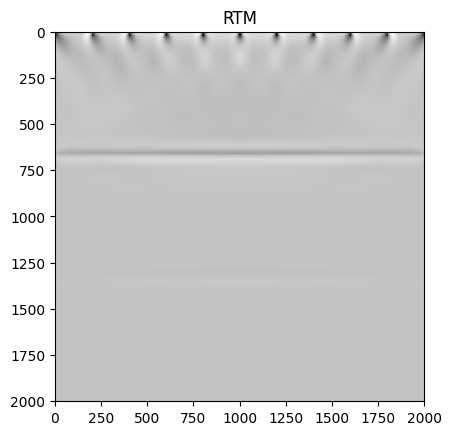

In [24]:
figure();
imshow(rtm', cmap="Greys", extent=[0, (shape[1]-1)*spacing[1], (shape[2]-1)*spacing[2], 0]);
title("RTM");